In [1]:
################ Higher moments global #################

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [ ]:
LAT        = 48.5
LON        = 236.25
#LAT        = 44.0682
#LON        = 360-114.7420
savefigs   = '/global/scratch/users/harsha/savefigs/Nov15/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/temps/'
tmax_path  = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/global/'
cvals_us   = '/global/scratch/users/harsha/LENS/cesm2/cvals/conus/'
loc        = 'columbia'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [3]:
#CONUS lat-lon
top = 50.0 # north lat
left = -124.7844079+360 # west long
right = -66.9513812+360 # east long
bottom =  24.7433195 # south lat

In [4]:
pi_yr0 = '1900'
pi_yr1 = '1930'
ic_yr0 = '2070'
ic_yr1 = '2100'
doy      = 1 # day_of_year
date     = 'Jan1'

In [5]:
#job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="lr6", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(15)

In [6]:
cluster

In [9]:
%%time
ds_ssp  = xr.open_mfdataset(tmax_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(tmax_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 564 ms, sys: 67.1 ms, total: 631 ms
Wall time: 707 ms


In [10]:
%%time
tw_us  = ds_ssp.TREFHTMX.sel(time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_yr0,ic_yr1))\
         .sel(lat=slice(bottom,top),lon=slice(left,right))
tnw_us = ds_hist.TREFHTMX.sel(time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_yr0,pi_yr1))\
         .sel(lat=slice(bottom,top),lon=slice(left,right))

CPU times: user 258 ms, sys: 2.9 ms, total: 261 ms
Wall time: 284 ms


In [ ]:
tw_us

In [13]:
%%time
tunw = tnw_us.stack(mtime=('member','time'),create_index=False)
tuw  = tw_us.stack(mtime=('member','time'),create_index=False)

CPU times: user 12 ms, sys: 1.06 ms, total: 13.1 ms
Wall time: 12.6 ms


In [14]:
tuc = (tuw - tuw.mean('mtime'))*(tunw.std('mtime')/tuw.std('mtime'))+ tunw.mean('mtime')

In [11]:
tunw_path = cvals_us+'tnw'+date+'_'+pi_yr0+'_'+pi_yr1+'_conus.nc'
tuw_path  = cvals_us+'tw'+date+'_'+ic_yr0+'_'+ic_yr1+'_conus.nc'
tuc_path  = cvals_us+'tc'+date+'_'+ic_yr0+'_'+ic_yr1+'_conus.nc'
print(tunw_path) 
print(tuw_path)
print(tuc_path)

/global/scratch/users/harsha/LENS/cesm2/cvals/conus/tnwJan1_1900_1930_conus.nc
/global/scratch/users/harsha/LENS/cesm2/cvals/conus/twJan1_2070_2100_conus.nc
/global/scratch/users/harsha/LENS/cesm2/cvals/conus/tcJan1_2070_2100_conus.nc


In [15]:
%%time
# Save daily,conus tmax
tunw.to_dataset().to_netcdf(tunw_path)
tuw.to_dataset().to_netcdf(tuw_path)
tuc.to_dataset().to_netcdf(tuc_path)

CPU times: user 28.8 s, sys: 1.18 s, total: 30 s
Wall time: 1min 40s


In [16]:
%%time
#Open conus data
tunw = xr.open_mfdataset(tunw_path,engine='netcdf4')
tuw  = xr.open_mfdataset(tuw_path,engine='netcdf4')
tuc  = xr.open_mfdataset(tuc_path,engine='netcdf4')
tuw  = tuw.TREFHTMX
tunw = tunw.TREFHTMX
tuc  = tuc.TREFHTMX
tuc

CPU times: user 139 ms, sys: 38.4 ms, total: 178 ms
Wall time: 696 ms


<xarray.DataArray 'TREFHTMX' (lat: 27, lon: 46, mtime: 3100)>
dask.array<open_dataset-eaee4085600fd1293d7256266f6fe27fTREFHTMX, shape=(27, 46, 3100), dtype=float32, chunksize=(27, 46, 3100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.97 25.92 26.86 27.8 ... 46.65 47.59 48.53 49.48
  * lon      (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5
    member   (mtime) int64 dask.array<chunksize=(3100,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime

In [35]:
tnw     = tunw.sel(lat=LAT,lon=LON,method='nearest')
tw      = tuw.sel(lat=LAT,lon=LON,method='nearest')
twc     = tuc.sel(lat=LAT,lon=LON,method='nearest')

In [54]:
%%time
skew_tnw = np.mean(np.power(tnw-tnw.mean('mtime'),3)/np.power(tnw.std('mtime'),3))
skew_tw  = np.mean(np.power(tw-tw.mean('mtime'),3)/np.power(tw.std('mtime'),3))
skew_twc = np.mean(np.power(twc-twc.mean('mtime'),3)/np.power(twc.std('mtime'),3))
#skew_tnw

CPU times: user 38.9 ms, sys: 6.04 ms, total: 44.9 ms
Wall time: 43.4 ms


<xarray.DataArray 'TREFHTMX' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 43.82
    lon      float64 245.0

In [55]:
%%time
skew_tnw.values

CPU times: user 34.6 ms, sys: 6.16 ms, total: 40.7 ms
Wall time: 156 ms


array(-1.0554252, dtype=float32)

In [56]:
skew_tw.values

array(-0.5280162, dtype=float32)

In [57]:
skew_twc.values

array(-0.5280369, dtype=float32)

In [20]:
%%time
#########
quants  = np.arange(0,1,0.001)
quw     = tuw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qunw    = tunw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
quc     = tuc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
quwa    = quw-qunw
quca    = quc-qunw
########################
quwa   = quwa.rename({'quantile':'permilles'})
quca   = quca.rename({'quantile':'permilles'})
quw    = quw.rename({'quantile':'permilles'}) 
qunw   = qunw.rename({'quantile':'permilles'}) 
quc    = quc.rename({'quantile':'permilles'})

CPU times: user 28.7 ms, sys: 71 µs, total: 28.8 ms
Wall time: 26.8 ms


In [21]:
#### Quantile paths-Conus
quw_path   = cvals_us+'qw'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qunw_path  = cvals_us+'qnw'+date+'_'+pi_yr0+'_'+pi_yr1+'.zarr'
quc_path   = cvals_us+'qc'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'

In [22]:
%%time
##### Save quantiles-Conus #########
quw.to_dataset().to_zarr(quw_path,mode='w')
qunw.to_dataset().to_zarr(qunw_path,mode='w')
quc.to_dataset().to_zarr(quc_path,mode='w')

CPU times: user 4.31 s, sys: 238 ms, total: 4.55 s
Wall time: 23.5 s


In [23]:
######### CONUS#################
qunw  = xr.open_mfdataset(qunw_path,engine='zarr')
quw   = xr.open_mfdataset(quw_path,engine='zarr')
quc   = xr.open_mfdataset(quc_path,engine='zarr')
qunw  = qunw.TREFHTMX
quw   = quw.TREFHTMX
quc   = quc.TREFHTMX
quwa  = quw-qunw 
quca  = quc-qunw #w= warming, a = anomaly
quwa

<xarray.DataArray 'TREFHTMX' (permilles: 1000, lat: 27, lon: 46)>
dask.array<sub, shape=(1000, 27, 46), dtype=float64, chunksize=(1000, 27, 46), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 24.97 25.92 26.86 27.8 ... 46.65 47.59 48.53 49.48
  * lon        (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

In [24]:
######### Calculate bootstrap confidence intervals for quatiles
#### CONUS ############
tunw= tunw.chunk(dict(mtime=-1))
tuw = tuw.chunk(dict(mtime=-1))
tuc = tuc.chunk(dict(mtime=-1))
dask.config.set({"array.slicing.split_large_chunks": True})  #Split large chunks
tuw

<xarray.DataArray 'TREFHTMX' (lat: 27, lon: 46, mtime: 3100)>
dask.array<open_dataset-8e71d845dfe6d67dadac0b7bae592e53TREFHTMX, shape=(27, 46, 3100), dtype=float32, chunksize=(27, 46, 3100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.97 25.92 26.86 27.8 ... 46.65 47.59 48.53 49.48
  * lon      (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5
    member   (mtime) int64 dask.array<chunksize=(3100,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

CPU times: user 184 ms, sys: 11.7 ms, total: 196 ms
Wall time: 650 ms


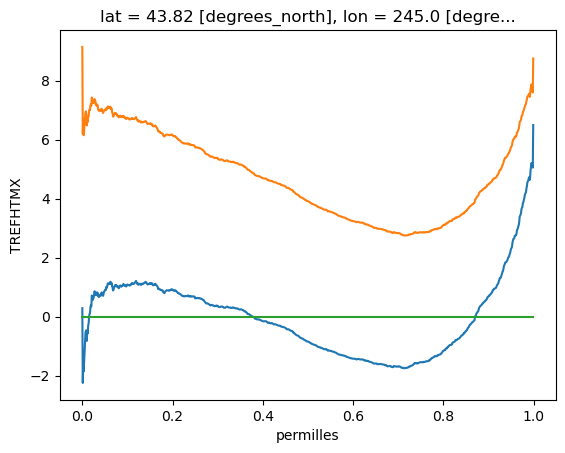

In [25]:
%%time
quca.sel(lat=LAT,lon=LON,method='nearest').plot()
quwa.sel(lat=LAT,lon=LON,method='nearest').plot()
yzero = np.zeros(1000)
plt.plot(quants,yzero)

In [26]:
%%time
############ CONUS ####################
nboot   = 1000
tunwb   = xs.resample_iterations(tunw,nboot,'mtime')
tuwb    = xs.resample_iterations(tuw,nboot,'mtime')
tucb    = xs.resample_iterations(tuc,nboot,'mtime')

CPU times: user 23.3 s, sys: 543 ms, total: 23.8 s
Wall time: 23.2 s


In [39]:
%%time
############ Conus ################
qunwb   = tunwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
quwb    = tuwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qucb    = tucb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
quwab   = quwb - qunwb
qucab   = qucb - qunwb
quwab

CPU times: user 59.2 ms, sys: 2.08 ms, total: 61.2 ms
Wall time: 58.3 ms


,Array,Chunk
Bytes,9.25 GiB,9.48 MiB
Shape,"(1000, 27, 46, 1000)","(1000, 27, 46, 1)"
Count,19004 Tasks,1000 Chunks
Type,float64,numpy.ndarray


In [41]:
############# CONUS #################
quwb_path    = cvals_us+'quwb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qunwb_path   = cvals_us+'qunwb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qucb_path    = cvals_us+'qucb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'

quwab_path   = cvals_us+'quwab'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
qucab_path   = cvals_us+'qucab'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'

quwab      = quwab.rename({'quantile':'permilles'})
qucab      = qucab.rename({'quantile':'permilles'})

In [42]:
%%time
######## CONUS ############
quwa_cilb = quwab.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
quwa_ciub = quwab.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')
quca_cilb = qucab.chunk(dict(iteration=-1)).quantile(0.025,dim='iteration')
quca_ciub = qucab.chunk(dict(iteration=-1)).quantile(0.975,dim='iteration')


CPU times: user 101 ms, sys: 2.96 ms, total: 104 ms
Wall time: 101 ms


In [43]:
########## CONUS ##############
quwa_cilbpath = cvals_us+'quwa_cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
quwa_ciubpath = cvals_us+'quwa_ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
quca_cilbpath = cvals_us+'quca_cilb'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
quca_ciubpath = cvals_us+'quca_ciub'+date+'_'+ic_yr0+'_'+ic_yr1+'.zarr'
quca_cilbpath

'/global/scratch/users/harsha/LENS/cesm2/cvals/conus/quca_cilbJan1_2070_2100.zarr'

In [44]:
%%time
#### Save bootstrap CIs #####
quwa_ciub.to_dataset().to_zarr(quwa_ciubpath,mode='w')

CPU times: user 1min 4s, sys: 2.21 s, total: 1min 6s
Wall time: 4min 26s


In [45]:
%%time
quwa_cilb.to_dataset().to_zarr(quwa_cilbpath,mode='w')

CPU times: user 1min 10s, sys: 2.54 s, total: 1min 13s
Wall time: 5min 3s


In [46]:
%%time
quca_ciub.to_dataset().to_zarr(quca_ciubpath,mode='w')

CPU times: user 1min 5s, sys: 2.27 s, total: 1min 7s
Wall time: 4min 28s


In [47]:
%%time
quca_cilb.to_dataset().to_zarr(quca_cilbpath,mode='w')

CPU times: user 1min 4s, sys: 2.23 s, total: 1min 6s
Wall time: 4min 27s


In [37]:
quwa_ciub = xr.open_mfdataset(quwa_ciubpath,engine='zarr')
quwa_cilb = xr.open_mfdataset(quwa_cilbpath,engine='zarr')

quca_ciub = xr.open_mfdataset(quca_ciubpath,engine='zarr')
quca_cilb = xr.open_mfdataset(quca_cilbpath,engine='zarr')
#quca_cilb = quca_cilb.TREFHTMX.drop('quantile')
#quca_ciub = quca_ciub.TREFHTMX.drop('quantile')
quca_ci   = xr.concat([quca_cilb,quca_ciub],dim='quantile')
quca_ci

<xarray.Dataset>
Dimensions:    (quantile: 2, permilles: 1000, lat: 27, lon: 46)
Coordinates:
  * lat        (lat) float64 24.97 25.92 26.86 27.8 ... 46.65 47.59 48.53 49.48
  * lon        (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
  * quantile   (quantile) float64 0.05 0.95
Data variables:
    TREFHTMX   (quantile, permilles, lat, lon) float64 dask.array<chunksize=(1, 1000, 27, 46), meta=np.ndarray>

In [39]:
%%time 
qus_lbfracn = ((quca_cilb >0)).sum(dim='permilles')/1000
qus_ubfracn = ((quca_ciub >0)).sum(dim='permilles')/1000

CPU times: user 9 ms, sys: 27 µs, total: 9.03 ms
Wall time: 8.65 ms


In [68]:
quca_fracnp  = ((quca_ci.sel(quantile=0.05)>0) & (quca_ci.sel(quantile=0.95)>0))\
                .sum(dim='permilles')/1000
quca_fracnn  = ((quca_ci.sel(quantile=0.05)<0) & (quca_ci.sel(quantile=0.95)<0))\
                .sum(dim='permilles')/1000

In [80]:
quca_fracn  = quca_fracnp +quca_fracnn
quca_fracn  = quca_fracn.TREFHTMX
quca_fracnp = quca_fracnp.TREFHTMX
quca_fracnn = quca_fracnn.TREFHTMX
quca_fracn

<xarray.DataArray 'TREFHTMX' (lat: 26, lon: 46)>
dask.array<add, shape=(26, 46), dtype=float64, chunksize=(26, 46), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.97 25.92 26.86 27.8 ... 45.71 46.65 47.59 48.53
  * lon      (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5

In [18]:
%%time
### Check for location
yzeros        = np.zeros(1000)
print(LAT,LON)
quca_cilb_loc = quca_cilb.sel(lat=LAT,lon=LON,method='nearest')
quca_ciub_loc = quca_ciub.sel(lat=LAT,lon=LON,method='nearest')
quwa_cilb_loc = quwa_cilb.sel(lat=LAT,lon=LON,method='nearest')
quwa_ciub_loc = quwa_ciub.sel(lat=LAT,lon=LON,method='nearest')
quca_loc      = quca.sel(lat=LAT,lon=LON,method='nearest')
quwa_loc      = quwa.sel(lat=LAT,lon=LON,method='nearest')

quca_ci_loc   = xr.concat([quca_cilb_loc,quca_ciub_loc],dim='quantile')

quca_fp       = ((quca_ci_loc.sel(quantile=0.05)>0) & (quca_ci_loc.sel(quantile=0.95)>0))\
                .sum(dim='permilles')/1000
quca_fn       = ((quca_ci_loc.sel(quantile=0.05)<0) & (quca_ci_loc.sel(quantile=0.95)<0))\
                .sum(dim='permilles')/1000
quca_fp       = quca_fp.TREFHTMX
quca_fn       = quca_fn.TREFHTMX
quca_f        = quca_fp + quca_fn

quca_cilb_loc = quca_cilb_loc.TREFHTMX
quca_ciub_loc = quca_ciub_loc.TREFHTMX
quwa_cilb_loc = quwa_cilb_loc.TREFHTMX
quwa_ciub_loc = quwa_ciub_loc.TREFHTMX


44.0682 245.25799999999998
CPU times: user 34.5 ms, sys: 16.1 ms, total: 50.7 ms
Wall time: 49.5 ms


In [105]:
%%time
print(quca_fp.values)
print(quca_fn.values)
print(quca_f.values)

0.426
0.449
0.875
CPU times: user 2.41 s, sys: 86.3 ms, total: 2.5 s
Wall time: 12.8 s


In [106]:
print(quca_fracn.sel(lat=LAT,lon=LON,method='nearest').values)

0.875


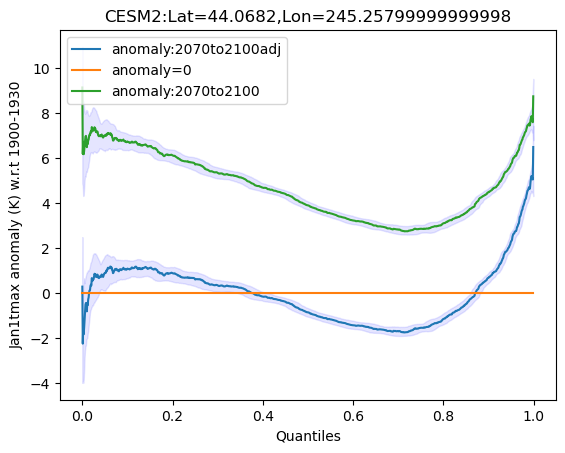

CPU times: user 1.93 s, sys: 81.6 ms, total: 2.01 s
Wall time: 14 s


In [19]:
%%time
quants = np.arange(0,1,0.001)
plt.plot(quants,quca_loc,label='anomaly:2070to2100adj')
plt.plot(quants,yzeros,label='anomaly=0')
plt.fill_between(quants,quca_cilb_loc,quca_ciub_loc,color='b',alpha=0.1)
plt.plot(quants,quwa_loc,label='anomaly:2070to2100')
plt.fill_between(quants,quwa_cilb_loc,quwa_ciub_loc,color='b',alpha=0.1)
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel(date+'tmax anomaly (K) w.r.t 1900-1930')
plt.xlabel('Quantiles')
plt.show()

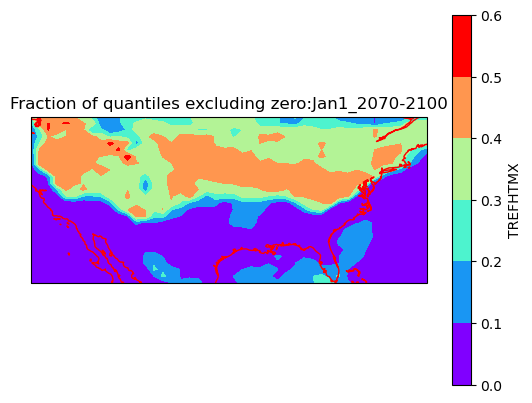

In [40]:
ax       = plt.axes(projection=cart.crs.PlateCarree())
#levs     = np.arange(-2,0.6,0.2)
qus_lbfracn.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree())
ax.coastlines(color="red")
plt.title('Fraction of quantiles excluding zero:Jan1_2070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

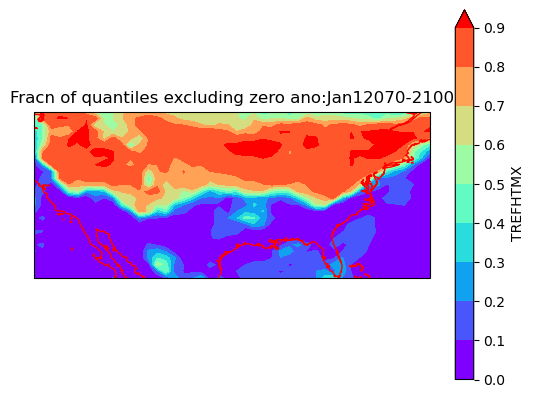

CPU times: user 751 ms, sys: 29.5 ms, total: 780 ms
Wall time: 2.44 s


In [79]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,1,0.1)
quca_fracn.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('Fracn of quantiles excluding zero ano:Jan12070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

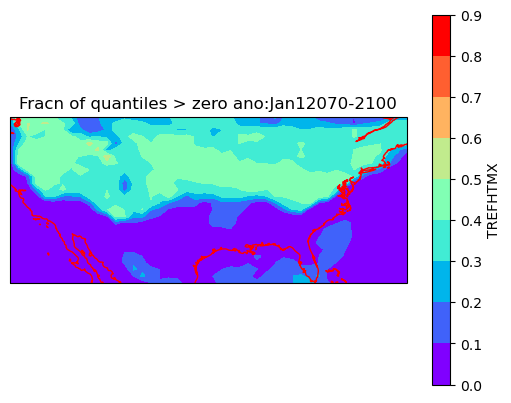

CPU times: user 693 ms, sys: 33.5 ms, total: 726 ms
Wall time: 2.47 s


In [82]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,1,0.1)
quca_fracnp.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('Fracn of quantiles > zero ano:Jan12070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

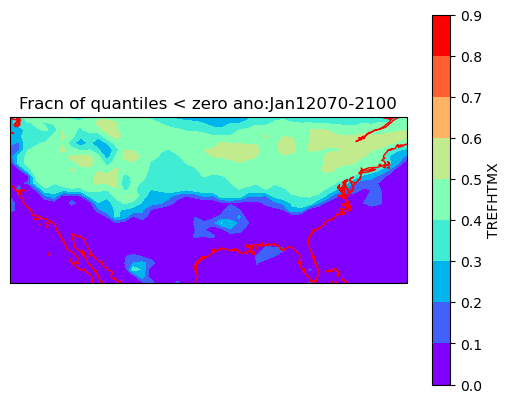

CPU times: user 740 ms, sys: 30.8 ms, total: 770 ms
Wall time: 2.45 s


In [83]:
%%time
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(0,1,0.1)
quca_fracnn.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="red")
plt.title('Fracn of quantiles < zero ano:Jan12070-2100')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()